# Importo librerias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.optimize import curve_fit
from scipy.stats import chi2
import pandas as pd

# Cargado de archivos

In [2]:
c = 3e8 #m/s
X, Y, V, nu = [], [], [], [] # --> Cada elemento de la lista corresponde a los datos de una longitud de onda

folder = 'Mediciones/Barrido voltaje dia 3'
fname = os.listdir(folder + '/')
files = fname[:9] + fname[-5:] # --> contiene primeras mediciones y los alts
for file in files:
    root = folder + '/' + file
    if file[:7] == 'barrido':
        medXYV = np.genfromtxt(root, delimiter = ',')
        N = len(medXYV)
        Xi, Yi, Vi = np.zeros(N - 1), np.zeros(N - 1), np.zeros(N - 1)
        for i, row in enumerate(medXYV[1:]):
            Xi[i], Yi[i], Vi[i] = row[0], row[1], row[2]
        X.append(Xi), Y.append(Yi), V.append(Vi)
        lamb = float(file[-9:-6])*1e-9 #m
        nu.append(c / lamb)

# Cálculo de $I$ y $V_0$

In [42]:
# Obtengo el V / I = 0
def V0min(x, v, epsilon = .05e-10, p = -1):
    xc = x[(x >= 0) & (x <= epsilon)]
    vc = v[(x >= 0) & (x <= epsilon)]

    xc0, vc0, ind_vc0 = xc[p], vc[p], np.where(v == vc[p])[0]
    err_vc0 = np.max([vc0 - v[ind_vc0 - 1], v[ind_vc0 + 1] - vc0])
    
    return xc0, vc0, err_vc0

def rectas(I, V):
    #--------Recorto datos para ajuste---------
    I_corte0, V_corte0 = I[10:30], V[10:30]
    I_corte1, V_corte1 = I[(V >= 0) & (V <= .5)], V[(V >= 0) & (V <= .5)]

    #--------Ajuste---------
    lin = lambda x, a, b: a*x + b
    popt0, pcov0 = curve_fit(lin, V_corte0, I_corte0) # --> Línea naranja
    popt1, pcov1 = curve_fit(lin, V_corte1, I_corte1) # --> Línea roja
    m, b = popt0
    m_, b_ = popt1
    
    #--------------------------
    # Buscamos la interseccion
    #--------------------------
    dm, db = (b - b_) / (m_ - m)**2, 1 / (m_ - m)
    dm_, db_ = -dm, -db
    
    V0_comun = (b_ - b) / (m - m_)
    var_v0_comun = dm**2 * ( pcov0[0][0] + pcov1[0][0] ) + 2*dm*db * ( pcov0[0][1] + pcov1[0][1]) + db**2 * ( pcov0[1][1] + pcov1[1][1] )

    return popt0, popt1, V0_comun, np.sqrt(var_v0_comun)


# Gráficos de las mediciones

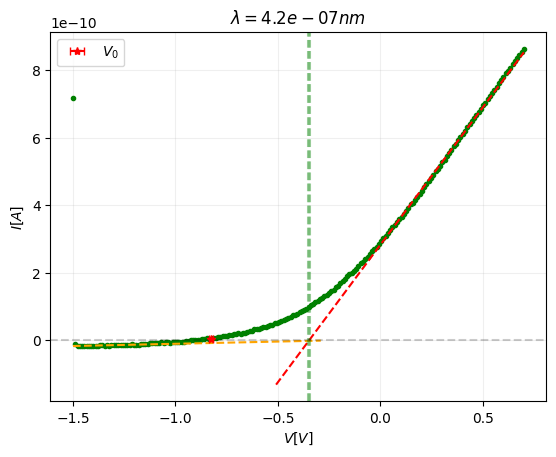

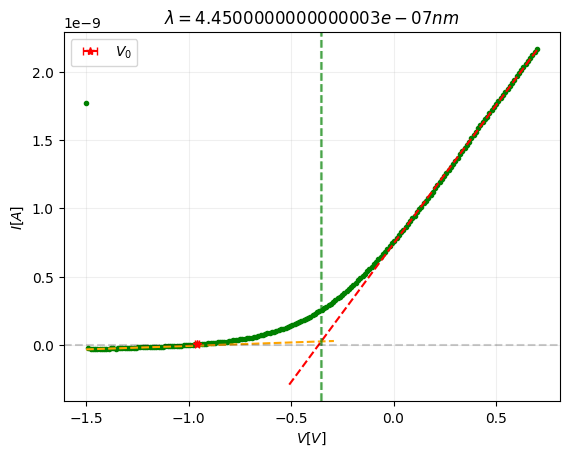

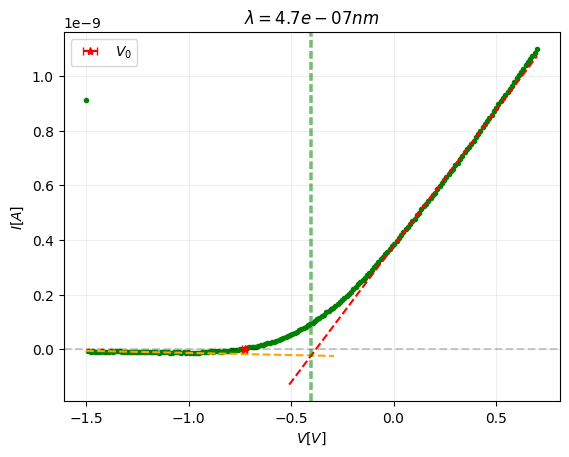

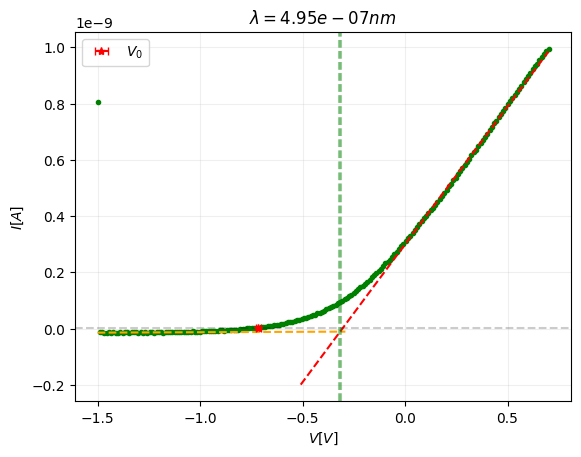

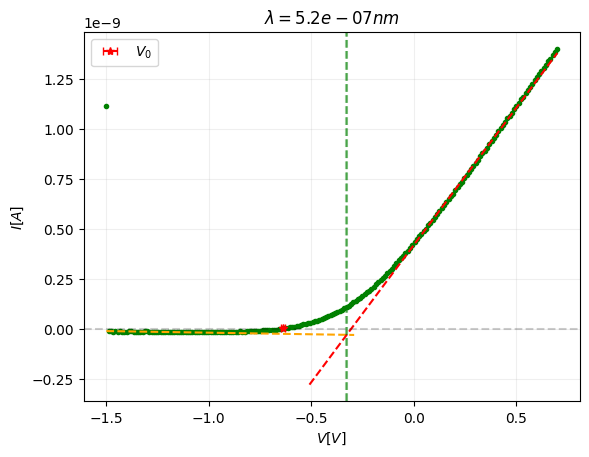

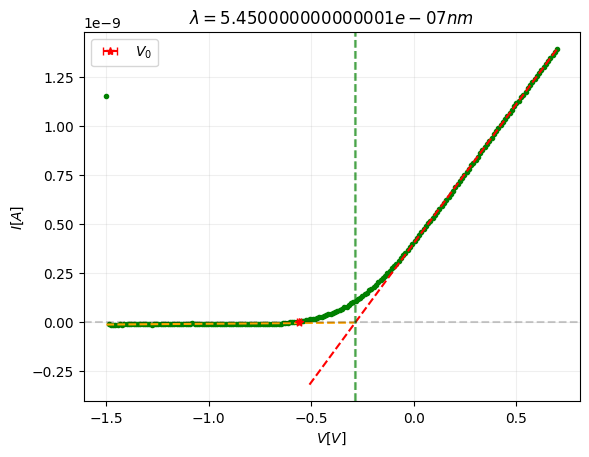

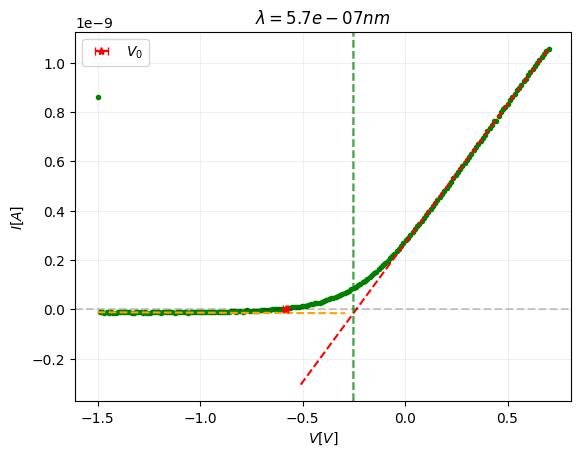

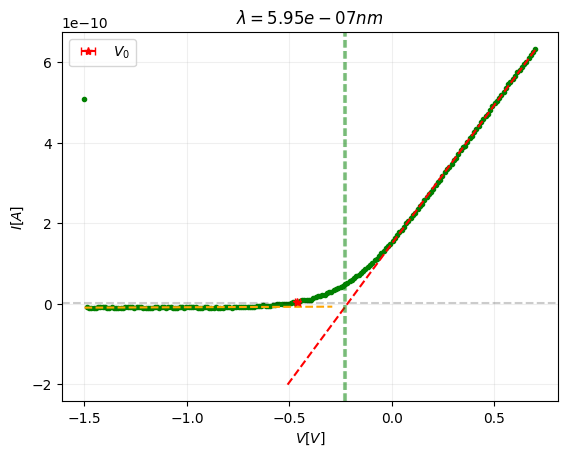

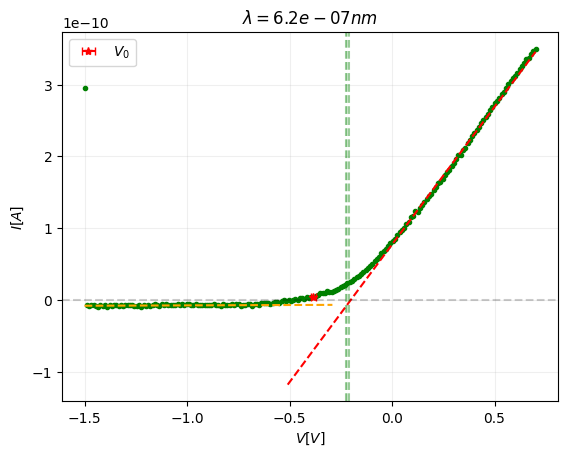

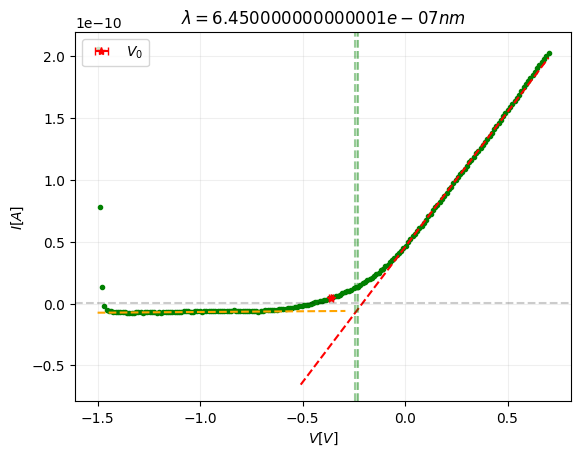

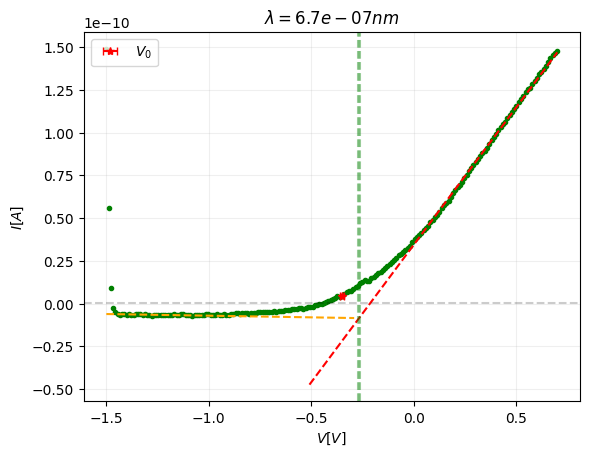

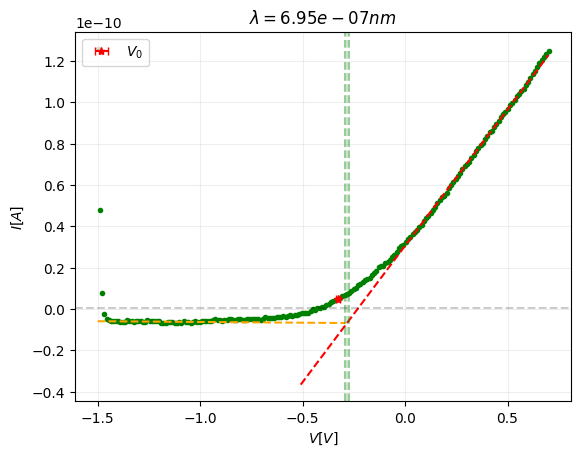

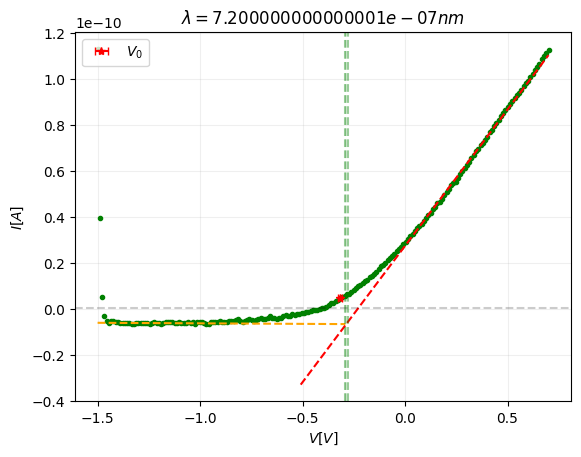

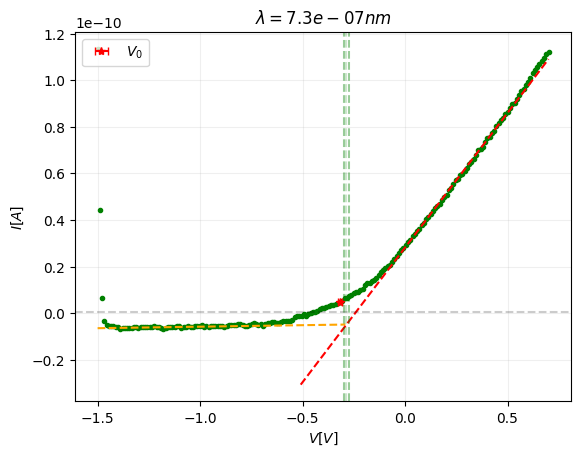

In [43]:
N = len(X)
V0, err_V0 = np.zeros((2, N))
V0C, err_V0C = np.zeros((2, N))

ep0 = .005e-10
for k in range(len(X)):
    # ----Calculamos ambos criterios----
    Xc0k, V0[k], err_V0[k] = V0min(-X[k], V[k])
    p0, p1, V0C[k], err_V0C[k] = rectas(-X[k], V[k])
        
    #---Calculo de las rectas-----
    f = lambda x, a, b: a * x + b
    v_sim = np.linspace(V[k][0], V[k][-1], 1000)

    #----Gráficos----
    plt.figure()
    
    plt.plot(V[k], -X[k], '.', color = 'green'), plt.plot()
    plt.plot(v_sim[:-450], f(v_sim, *p0)[:-450], '--', color = 'orange')
    plt.plot(v_sim[450:], f(v_sim, *p1)[450:], '--', color = 'red')

    plt.errorbar(V0[k], Xc0k, fmt = '*', xerr = err_V0[k], capsize = 3, 
                    linestyle = 'None', color = 'red', label = r'$V_0$') #-->Puntos de corriente nula
    
    plt.axvline(V0C[k], linestyle = '--', color = 'green', alpha = 0.2)
    plt.axvline(V0C[k] + err_V0C[k], linestyle = '--', color = 'green', alpha = 0.4)
    plt.axvline(V0C[k] - err_V0C[k], linestyle = '--', color = 'green', alpha = 0.4)
    
    plt.axhline(ep0, linestyle = '--', color = 'black', alpha = 0.2)
    
    plt.xlabel(r'$V \left[V\right]$'), plt.ylabel(r'$I \left[A\right]$'), plt.title(rf'$\lambda = {c/nu[k]} nm$')
    plt.grid(alpha = 0.2), plt.legend(loc = 'upper left')
    plt.show()

# Gráficos de ajuste

Función de ajuste:
$eV_0 = h \nu - \hat{\phi}$

0.002161926543468304 1.0
Método visual : 3.3301575032348513e-34 +- 5.003998556287822e-36
Método rectas : 8.404985524648144e-35 +- 1.722546716978497e-35


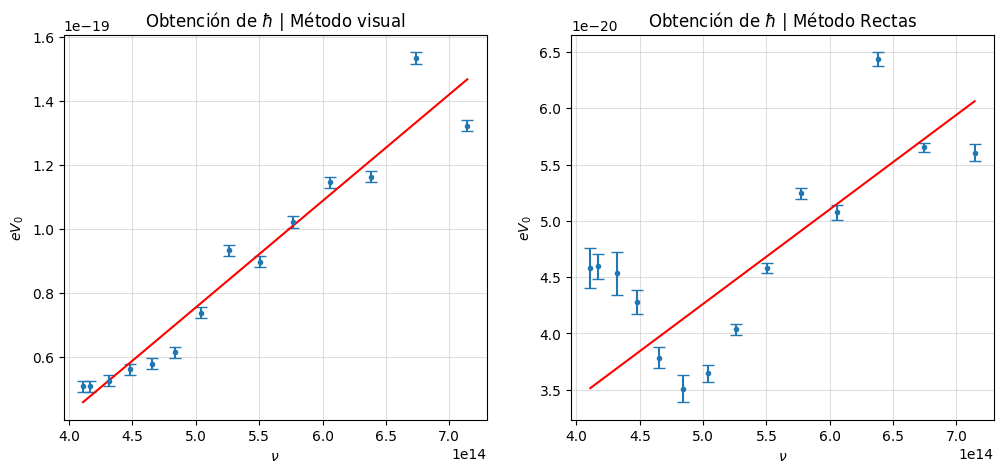

In [44]:
# Defino e y paso a arrayos
elect = -1.60217663e-19 #C
V0, err_V0 = np.array(V0), np.array(err_V0)
V0C, err_V0C = np.array(V0C), np.array(err_V0C)

# ------------Ajuste lineal------------
f = lambda x, a, c: a * x + c

# --> Ajuste para método visual
popt, pcov = curve_fit(f, nu, elect*V0, sigma = elect*err_V0, p0 = [6e-34, 1.4e-19], absolute_sigma = True)
h, err_h = popt[0], np.sqrt(np.diag(pcov))[0]

#chi2
df = N - 2
Chi2 = sum( ( (elect*V0 - f(elect*V0, *popt)) / elect*err_V0 )**2 )
p_valor = 1 - chi2(df = df).cdf(Chi2)
print(Chi2, p_valor)

# --> Ajuste para método por rectas
poptC, pcovC = curve_fit(f, nu, elect*V0C, sigma = elect*err_V0C)
hC, err_hC = poptC[0], np.sqrt(np.diag(pcovC))[0]


# -----------Gráfico de ajustes----------
fig, axs = plt.subplots(1, 2, figsize = (12, 5))

# ---> Método visual
axs[0].errorbar(nu, elect*V0, fmt = '.', yerr = -elect*err_V0, capsize = 4)
axs[0].plot(nu, f(np.array(nu), *popt), color = 'red')
axs[0].set(title = r'Obtención de $\hbar$ | Método visual', ylabel = r'$eV_0$', xlabel = r'$\nu$')
axs[0].grid(alpha = 0.4)

# ---> Método rectas
axs[1].errorbar(nu, elect*V0C, fmt = '.', yerr = -elect*err_V0C, capsize = 4)
axs[1].plot(nu, f(np.array(nu), *poptC), color = 'red')
axs[1].set(title = r'Obtención de $\hbar$ | Método Rectas', ylabel = r'$eV_0$', xlabel = r'$\nu$')
axs[1].grid(alpha = 0.4)

print(f'Método visual : {h} +- {err_h}')
print(f'Método rectas : {hC} +- {err_hC}')


## Barrido de longitudes (dia 3)

### Cargamos los datos

In [28]:
df = pd.read_csv('Mediciones/Barrido de longitudes/medicion_completa.csv')
long_ond = np.array(df['long']) / 1e9 # m
I_5v, nu_odna = -df['X'], c / long_ond

### Usamos criterios de selección

In [31]:
# Busco los valores
nus = nu_odna[(nu_odna <= 4.25e14) & (nu_odna >= 4e14)]
Is = I_5v[(nu_odna <= 4.25e14) & (nu_odna >= 4e14)]

# Tomo promedios y como error la mayor distancia
nu0= np.mean(nus)
err_nu0 = np.max([nu0 - nus[0], nus[-1] - nu0])

### Gráfico

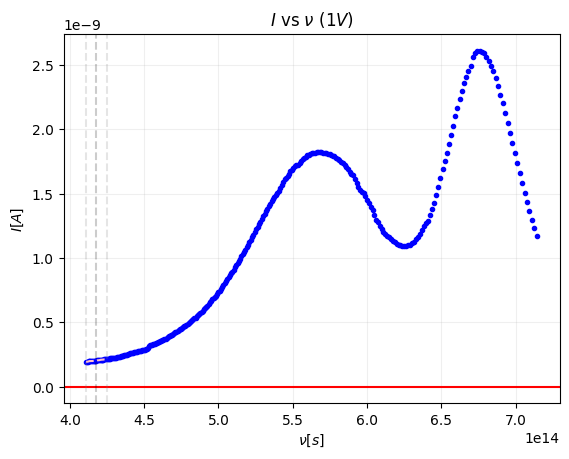

In [32]:
plt.figure()

plt.plot(nu_odna, I_5v, '.', color = 'blue'), plt.axhline(0, color = 'red')
plt.plot(nus, Is, '--', color = 'pink')

plt.axvline(nu0, linestyle = '--', color = 'black', alpha = 0.2)
plt.axvline(nu0 + err_nu0, linestyle = '--', color = 'gray', alpha = 0.2)
plt.axvline(nu0 - err_nu0, linestyle = '--', color = 'gray', alpha = 0.2)

plt.title(r'$I$ vs $\nu$ $(1V)$'), plt.ylabel(r'$I[A]$'), plt.xlabel(r'$\nu[s]$')
plt.grid(alpha = 0.2)
plt.show()

In [33]:
# Calculos del potencial
pot, err_pot = nu0 * h, np.sqrt(nu0 * err_nu0**2 + h * err_h**2)

print(pot, err_pot)

1.391571083046746e-19 1.4431392399544238e+20
